# Chapter 7: Rotation Initialization with Chordal Relaxation

## 🎯 Learning Objectives
- Understand the rotation synchronization problem
- Learn about chordal relaxation for SO(3) optimization
- Implement rotation initialization algorithms
- Compare different initialization strategies
- Apply rotation initialization to pose graph optimization

## 🏗️ Why Initialization Matters: Setting the Stage for Success

Imagine you're building a house. If you start with a crooked foundation, even the most skilled carpenters will struggle to create a stable structure. The same principle applies to pose graph optimization. **Initialization is the foundation upon which your entire pose graph solution is built.**

### The Optimization Landscape ⛰️

Pose graph optimization is like finding the lowest point in a bumpy landscape:
- **Good initialization**: Places you near the valley (global minimum)
- **Bad initialization**: Drops you on the wrong mountain (local minimum)
- **Terrible initialization**: Leaves you on a cliff (no convergence)

### Why Good Initialization is Critical:

1. **Avoid Local Minima Traps** 🪤
   - Poor initialization → optimizer gets stuck in suboptimal solutions
   - Your map becomes distorted or completely wrong

2. **Computational Efficiency** ⚡
   - Good initialization: 10-20 iterations to converge
   - Bad initialization: 100+ iterations or no convergence
   - Critical for real-time SLAM!

3. **Guarantee Convergence** ✅
   - Some initializations prevent convergence entirely
   - The optimizer might oscillate or diverge

4. **Accuracy of Final Solution** 🎯
   - Even if it converges, bad initialization → worse final accuracy
   - Small initial errors can amplify during optimization

**In short:** Good initialization isn't just about speed; it's about finding a valid solution at all!

## 1. The Rotation Synchronization Problem

In pose graph optimization, good initialization is crucial for convergence to the global minimum. The rotation synchronization problem asks:

Given relative rotation measurements $R_{ij}$ between poses $i$ and $j$, find absolute rotations $R_i$ that best satisfy:

$$R_j \approx R_i R_{ij}$$

This is a non-convex problem due to the SO(3) manifold constraint: $R^T R = I$ and $\det(R) = 1$.

### 🧭 Visualizing Rotation Synchronization: The Compass Analogy

Imagine you have a set of compasses scattered across a field:
- Each compass doesn't know which way is North (absolute orientation)
- But each compass DOES know its angle relative to nearby compasses
- **Goal**: Figure out which way each compass points in absolute terms

<div style="text-align: center; margin: 20px;">
<svg width="400" height="300" viewBox="0 0 400 300">
  <!-- Compass 1 -->
  <circle cx="100" cy="150" r="30" fill="lightblue" stroke="blue"/>
  <line x1="100" y1="150" x2="100" y2="120" stroke="red" stroke-width="3" marker-end="url(#arrowhead)"/>
  <text x="90" y="190" font-size="12">C1</text>
  
  <!-- Compass 2 -->
  <circle cx="200" cy="100" r="30" fill="lightblue" stroke="blue"/>
  <line x1="200" y1="100" x2="225" y2="85" stroke="red" stroke-width="3" marker-end="url(#arrowhead)"/>
  <text x="190" y="140" font-size="12">C2</text>
  
  <!-- Compass 3 -->
  <circle cx="300" cy="150" r="30" fill="lightblue" stroke="blue"/>
  <line x1="300" y1="150" x2="320" y2="170" stroke="red" stroke-width="3" marker-end="url(#arrowhead)"/>
  <text x="290" y="190" font-size="12">C3</text>
  
  <!-- Relative measurements -->
  <path d="M 130 140 Q 150 120 170 110" stroke="green" stroke-width="2" fill="none" stroke-dasharray="5,5"/>
  <text x="140" y="115" font-size="10" fill="green">30°</text>
  
  <path d="M 230 110 Q 250 130 270 140" stroke="green" stroke-width="2" fill="none" stroke-dasharray="5,5"/>
  <text x="240" y="135" font-size="10" fill="green">45°</text>
  
  <!-- Arrow marker -->
  <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="9" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" fill="red"/>
    </marker>
  </defs>
</svg>
</div>

### 💃 The Dancer Analogy

Another way to think about it:
- Imagine dancers in a line, each facing the next dancer
- Each knows how much to rotate to face their neighbor
- But nobody knows which way the stage front is!
- **Rotation synchronization** finds each dancer's orientation relative to the stage

### 🌍 Real-World Applications

This problem appears everywhere in robotics and computer vision:
- **Multi-robot SLAM**: Robots share relative measurements
- **Structure from Motion**: Cameras with relative orientations
- **Sensor network calibration**: Distributed sensors needing alignment

## 🚨 Real-World Failure Cases: When Bad Initialization Goes Wrong

Poor initialization isn't just a theoretical problem - it causes real failures:

### 1. **SLAM in Feature-Poor Environments** 🏢
Imagine a robot navigating a long corridor with identical walls:
- Initial orientation guess is slightly off
- Optimizer struggles with loop closure
- Result: "Twisted" map where the corridor doesn't close properly

**Example**: Indoor mapping robots often fail in symmetric environments like parking garages or office corridors when initialization is poor.

### 2. **Visual Odometry with Fast Rotations** 🎥
When a camera undergoes sudden rotation:
- Standard visual odometry loses track
- Bad initial guess → optimizer fails completely
- Result: Complete tracking loss, robot gets "lost"

**Real Case**: Drone racing where aggressive maneuvers cause visual SLAM failure due to poor rotation initialization.

### 3. **Multi-Robot Mapping** 🤖🤖
Multiple robots exploring the same area:
- Each robot has its own coordinate frame
- Without good initialization, maps don't align
- Result: Duplicate or misaligned features in the combined map

### 4. **Augmented Reality (AR) Applications** 📱
AR apps overlaying virtual objects:
- Poor initial pose estimation
- Virtual objects appear misaligned or "floating"
- Result: Broken immersion, poor user experience

**These failures show that good initialization is critical for real-world applications!**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.linalg import svd, eigh
import networkx as nx
from typing import List, Tuple, Dict, Optional
import time
from mpl_toolkits.mplot3d import Axes3D

## 2. Rotation Representations and Utilities

In [ ]:
## 3. Chordal Relaxation

The key insight of chordal relaxation is to relax the SO(3) constraint and solve:

$$\min_{R_i \in \mathbb{R}^{3×3}} \sum_{(i,j) \in \mathcal{E}} w_{ij} \|R_i - R_j R_{ij}^T\|_F^2$$

This is a convex problem! After solving, we project each $R_i$ back to SO(3).

### 🎯 The Brilliant Trick: From Curved to Flat

The genius of chordal relaxation:
1. **Original problem**: Optimize on the curved manifold SO(3) (hard!)
2. **Relaxed problem**: Optimize in flat Euclidean space ℝ³ˣ³ (easy!)
3. **Project back**: Find nearest valid rotation (simple SVD)

It's like:
- Instead of finding the shortest path on Earth's curved surface
- We temporarily "flatten" the Earth, find the path
- Then project back to the sphere!

### 📐 Why "Chordal"?

The name comes from the **chordal distance** between rotations:
- **Geodesic distance**: Arc length on the sphere (true distance)
- **Chordal distance**: Straight line through the sphere

<div style="text-align: center; margin: 20px;">
<svg width="300" height="200" viewBox="0 0 300 200">
  <!-- Sphere -->
  <ellipse cx="150" cy="100" rx="80" ry="80" fill="none" stroke="blue" stroke-width="2"/>
  
  <!-- Two points on sphere -->
  <circle cx="110" cy="50" r="5" fill="red"/>
  <circle cx="190" cy="50" r="5" fill="red"/>
  
  <!-- Geodesic (arc) -->
  <path d="M 110 50 Q 150 20 190 50" stroke="green" stroke-width="3" fill="none"/>
  <text x="140" y="15" font-size="12" fill="green">Geodesic</text>
  
  <!-- Chord -->
  <line x1="110" y1="50" x2="190" y2="50" stroke="orange" stroke-width="3" stroke-dasharray="5,5"/>
  <text x="130" y="65" font-size="12" fill="orange">Chord</text>
</svg>
</div>

Chordal relaxation minimizes the chordal distance, which is easier to optimize!

## 3. Chordal Relaxation

The key insight of chordal relaxation is to relax the SO(3) constraint and solve:

$$\min_{R_i \in \mathbb{R}^{3×3}} \sum_{(i,j) \in \mathcal{E}} w_{ij} \|R_i - R_j R_{ij}^T\|_F^2$$

This is a convex problem! After solving, we project each $R_i$ back to SO(3).

In [ ]:
## 4. Alternative: Iterative Rotation Averaging

Another approach is to iteratively update rotations using the tangent space of SO(3).

### 🔄 The Consensus Approach

Iterative rotation averaging works like reaching consensus:
1. Each rotation "votes" based on its neighbors
2. Update each rotation toward the average vote
3. Repeat until consensus is reached

It's like:
- A group of people trying to synchronize their watches
- Each person adjusts based on their neighbors' times
- Eventually everyone converges to synchronized time

### Advantages vs Chordal Relaxation:

| Method | Pros | Cons | Best For |
|--------|------|------|----------|
| **Chordal** | Fast, global solution, convex | Sensitive to outliers | Dense graphs, clean data |
| **Iterative** | Can handle constraints, robust options | Local minima, slower | Sparse graphs, noisy data |

## 4. Alternative: Iterative Rotation Averaging

Another approach is to iteratively update rotations using the tangent space of SO(3).

In [ ]:
## 5. Testing Rotation Synchronization

Let's test both algorithms on synthetic data to understand their behavior.

## 5. Testing Rotation Synchronization

In [23]:
def create_synthetic_rotation_graph(n_vertices: int = 10, 
                                  connectivity: float = 0.3,
                                  noise_level: float = 0.1) -> Tuple[RotationGraph, Dict[int, np.ndarray]]:
    """Create a synthetic rotation graph with known ground truth"""
    graph = RotationGraph()
    
    # Generate ground truth rotations
    ground_truth = {}
    for i in range(n_vertices):
        if i == 0:
            ground_truth[i] = np.eye(3)
        else:
            # Random rotation
            axis = np.random.randn(3)
            axis /= np.linalg.norm(axis)
            angle = np.random.uniform(0, np.pi)
            ground_truth[i] = rotation_matrix_from_axis_angle(axis, angle)
        graph.add_vertex(i)
    
    # Add edges
    n_edges = 0
    for i in range(n_vertices):
        for j in range(i + 1, n_vertices):
            if np.random.random() < connectivity:
                # Compute relative rotation
                R_ij_true = ground_truth[i].T @ ground_truth[j]
                
                # Add noise
                noise_axis = np.random.randn(3)
                noise_axis /= np.linalg.norm(noise_axis)
                noise_angle = np.random.normal(0, noise_level)
                R_noise = rotation_matrix_from_axis_angle(noise_axis, noise_angle)
                
                R_ij_measured = R_noise @ R_ij_true
                
                graph.add_edge(i, j, R_ij_measured)
                n_edges += 1
    
    print(f"Created graph with {n_vertices} vertices and {n_edges} edges")
    return graph, ground_truth

# Test the algorithms
np.random.seed(42)
graph, ground_truth = create_synthetic_rotation_graph(n_vertices=15, 
                                                     connectivity=0.4,
                                                     noise_level=0.1)

Created graph with 15 vertices and 35 edges


In [24]:
# Solve using chordal relaxation
print("Solving with chordal relaxation...")
start_time = time.time()
rotations_chordal = graph.solve_chordal_relaxation(anchor_id=0)
time_chordal = time.time() - start_time

# Solve using iterative averaging
print("\nSolving with iterative averaging...")
solver_iterative = IterativeRotationAveraging(graph)
start_time = time.time()
rotations_iterative, history_iterative = solver_iterative.solve(max_iterations=100)
time_iterative = time.time() - start_time

# Compute errors
def compute_rotation_errors(estimated: Dict[int, np.ndarray], 
                          ground_truth: Dict[int, np.ndarray]) -> Dict[str, float]:
    errors = []
    for v in estimated:
        error = geodesic_distance_SO3(estimated[v], ground_truth[v])
        errors.append(error)
    
    return {
        'mean': np.mean(errors),
        'max': np.max(errors),
        'median': np.median(errors),
        'std': np.std(errors)
    }

errors_chordal = compute_rotation_errors(rotations_chordal, ground_truth)
errors_iterative = compute_rotation_errors(rotations_iterative, ground_truth)

print(f"\nChordal Relaxation (time: {time_chordal:.3f}s):")
for metric, value in errors_chordal.items():
    print(f"  {metric}: {value:.4f} rad ({np.degrees(value):.2f} deg)")

print(f"\nIterative Averaging (time: {time_iterative:.3f}s):")
for metric, value in errors_iterative.items():
    print(f"  {metric}: {value:.4f} rad ({np.degrees(value):.2f} deg)")

Solving with chordal relaxation...

Solving with iterative averaging...

Chordal Relaxation (time: 0.006s):
  mean: 1.5705 rad (89.98 deg)
  max: 3.1088 rad (178.12 deg)
  median: 1.6998 rad (97.39 deg)
  std: 1.0455 rad (59.90 deg)

Iterative Averaging (time: 0.106s):
  mean: 1.0569 rad (60.55 deg)
  max: 2.6030 rad (149.14 deg)
  median: 0.8328 rad (47.72 deg)
  std: 0.8426 rad (48.28 deg)


## 6. Visualizing Rotation Errors

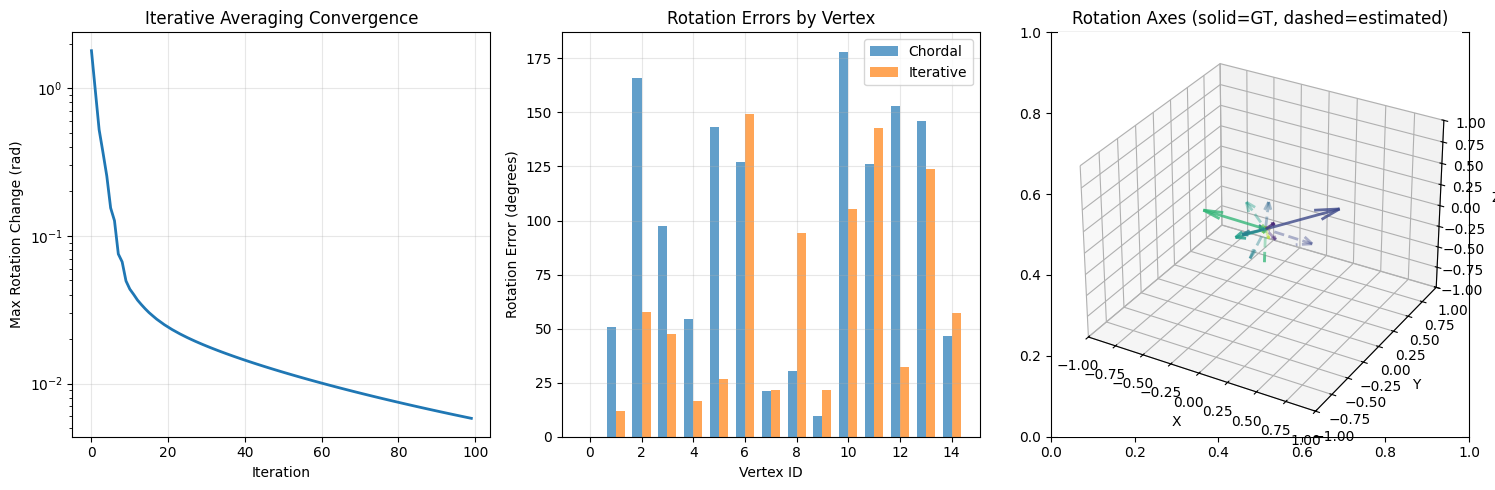

In [25]:
# Visualize convergence and errors
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Convergence of iterative method
ax = axes[0]
ax.semilogy(history_iterative, linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Max Rotation Change (rad)')
ax.set_title('Iterative Averaging Convergence')
ax.grid(True, alpha=0.3)

# Error distribution comparison
ax = axes[1]
vertices = sorted(ground_truth.keys())
errors_c = [geodesic_distance_SO3(rotations_chordal[v], ground_truth[v]) for v in vertices]
errors_i = [geodesic_distance_SO3(rotations_iterative[v], ground_truth[v]) for v in vertices]

x = np.arange(len(vertices))
width = 0.35
ax.bar(x - width/2, np.degrees(errors_c), width, label='Chordal', alpha=0.7)
ax.bar(x + width/2, np.degrees(errors_i), width, label='Iterative', alpha=0.7)
ax.set_xlabel('Vertex ID')
ax.set_ylabel('Rotation Error (degrees)')
ax.set_title('Rotation Errors by Vertex')
ax.legend()
ax.grid(True, alpha=0.3)

# Visualize rotation axes
ax = axes[2]
ax = plt.subplot(1, 3, 3, projection='3d')

# Plot rotation axes for a subset of vertices
vertices_to_plot = vertices[:min(10, len(vertices))]
colors = plt.cm.viridis(np.linspace(0, 1, len(vertices_to_plot)))

for idx, v in enumerate(vertices_to_plot):
    # Ground truth axis
    axis_gt, angle_gt = rotation_matrix_to_axis_angle(ground_truth[v])
    if abs(angle_gt) > 0.01:
        ax.quiver(0, 0, 0, axis_gt[0], axis_gt[1], axis_gt[2], 
                 color=colors[idx], alpha=0.8, linewidth=2, 
                 length=angle_gt/np.pi, label=f'V{v} GT' if idx < 3 else '')
    
    # Estimated axis (chordal)
    axis_est, angle_est = rotation_matrix_to_axis_angle(rotations_chordal[v])
    if abs(angle_est) > 0.01:
        ax.quiver(0, 0, 0, axis_est[0], axis_est[1], axis_est[2], 
                 color=colors[idx], alpha=0.4, linewidth=2, linestyle='--',
                 length=angle_est/np.pi)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Rotation Axes (solid=GT, dashed=estimated)')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
if len(vertices_to_plot) <= 3:
    ax.legend()

plt.tight_layout()
plt.show()

## 7. Robustness to Outliers

Let's test how these methods handle outlier measurements.

In [26]:
def add_outliers_to_graph(graph: RotationGraph, outlier_ratio: float = 0.1) -> RotationGraph:
    """Add outlier measurements to the graph"""
    n_outliers = int(len(graph.edges) * outlier_ratio)
    outlier_indices = np.random.choice(len(graph.edges), n_outliers, replace=False)
    
    new_graph = RotationGraph()
    for v in graph.vertices:
        new_graph.add_vertex(v)
    
    for idx, (i, j, R_ij, weight) in enumerate(graph.edges):
        if idx in outlier_indices:
            # Create random rotation as outlier
            axis = np.random.randn(3)
            axis /= np.linalg.norm(axis)
            angle = np.random.uniform(0, np.pi)
            R_outlier = rotation_matrix_from_axis_angle(axis, angle)
            new_graph.add_edge(i, j, R_outlier, weight)
        else:
            new_graph.add_edge(i, j, R_ij, weight)
    
    return new_graph

# Test with different outlier ratios
outlier_ratios = [0.0, 0.1, 0.2, 0.3]
results = {'chordal': [], 'iterative': []}

for outlier_ratio in outlier_ratios:
    print(f"\nTesting with {outlier_ratio*100:.0f}% outliers...")
    
    # Create graph with outliers
    graph_clean, ground_truth = create_synthetic_rotation_graph(n_vertices=20, 
                                                               connectivity=0.3,
                                                               noise_level=0.05)
    graph_outliers = add_outliers_to_graph(graph_clean, outlier_ratio)
    
    # Solve with both methods
    rotations_chordal = graph_outliers.solve_chordal_relaxation(anchor_id=0)
    solver_iterative = IterativeRotationAveraging(graph_outliers)
    rotations_iterative, _ = solver_iterative.solve(max_iterations=100)
    
    # Compute errors
    errors_c = compute_rotation_errors(rotations_chordal, ground_truth)
    errors_i = compute_rotation_errors(rotations_iterative, ground_truth)
    
    results['chordal'].append(errors_c['mean'])
    results['iterative'].append(errors_i['mean'])
    
    print(f"  Chordal: mean error = {np.degrees(errors_c['mean']):.2f} deg")
    print(f"  Iterative: mean error = {np.degrees(errors_i['mean']):.2f} deg")


Testing with 0% outliers...
Created graph with 20 vertices and 53 edges
  Chordal: mean error = 90.76 deg
  Iterative: mean error = 86.31 deg

Testing with 10% outliers...
Created graph with 20 vertices and 55 edges
  Chordal: mean error = 92.53 deg
  Iterative: mean error = 68.88 deg

Testing with 20% outliers...
Created graph with 20 vertices and 63 edges
  Chordal: mean error = 86.39 deg
  Iterative: mean error = 74.96 deg

Testing with 30% outliers...
Created graph with 20 vertices and 69 edges
  Chordal: mean error = 83.43 deg
  Iterative: mean error = 43.18 deg


## 8. Application to Full Pose Graph Optimization

Now let's use rotation initialization as a preprocessing step for full pose graph optimization.

### 🔗 The Complete Pipeline

Good pose graph optimization follows this pipeline:

```
1. Rotation Initialization (this chapter)
   ↓
2. Position Initialization (using fixed rotations)
   ↓
3. Full Pose Graph Optimization (translation + rotation)
```

This hierarchical approach dramatically improves convergence!

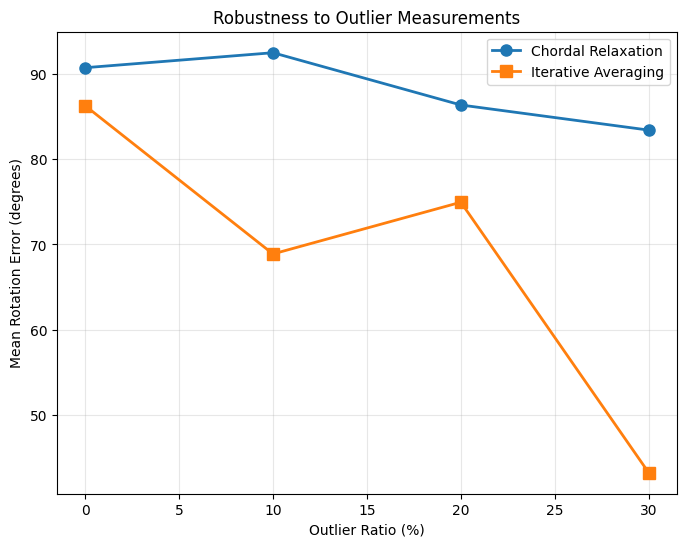

In [27]:
# Plot robustness results
plt.figure(figsize=(8, 6))
plt.plot([r*100 for r in outlier_ratios], np.degrees(results['chordal']), 
         'o-', linewidth=2, markersize=8, label='Chordal Relaxation')
plt.plot([r*100 for r in outlier_ratios], np.degrees(results['iterative']), 
         's-', linewidth=2, markersize=8, label='Iterative Averaging')
plt.xlabel('Outlier Ratio (%)')
plt.ylabel('Mean Rotation Error (degrees)')
plt.title('Robustness to Outlier Measurements')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Application to Full Pose Graph Optimization

Now let's use rotation initialization as a preprocessing step for full pose graph optimization.

In [28]:
class PoseGraphWithRotationInit:
    def __init__(self):
        self.vertices = {}  # id -> (x, y, theta)
        self.edges = []     # (i, j, dx, dy, dtheta, info_matrix)
        self.rotation_graph = RotationGraph()
    
    def add_vertex(self, vertex_id: int, x: float, y: float, theta: float):
        self.vertices[vertex_id] = np.array([x, y, theta])
        self.rotation_graph.add_vertex(vertex_id)
    
    def add_edge(self, i: int, j: int, dx: float, dy: float, dtheta: float,
                 info_matrix: np.ndarray = None):
        if info_matrix is None:
            info_matrix = np.eye(3)
        self.edges.append((i, j, np.array([dx, dy, dtheta]), info_matrix))
        
        # Add to rotation graph (2D rotation as 3D rotation around z-axis)
        R_ij = np.array([
            [np.cos(dtheta), -np.sin(dtheta), 0],
            [np.sin(dtheta), np.cos(dtheta), 0],
            [0, 0, 1]
        ])
        self.rotation_graph.add_edge(i, j, R_ij, info_matrix[2, 2])
    
    def initialize_with_rotation_sync(self, method: str = 'chordal'):
        """Initialize poses using rotation synchronization"""
        print(f"Initializing rotations using {method} method...")
        
        if method == 'chordal':
            rotations_3d = self.rotation_graph.solve_chordal_relaxation(anchor_id=0)
        else:
            solver = IterativeRotationAveraging(self.rotation_graph)
            rotations_3d, _ = solver.solve()
        
        # Extract 2D rotations
        for v in self.vertices:
            R = rotations_3d[v]
            # Extract rotation around z-axis
            theta = np.arctan2(R[1, 0], R[0, 0])
            self.vertices[v][2] = theta
        
        # Now initialize positions using a simple spanning tree approach
        visited = set([0])
        queue = [0]
        
        while queue:
            current = queue.pop(0)
            
            for i, j, measurement, _ in self.edges:
                next_vertex = None
                if i == current and j not in visited:
                    next_vertex = j
                    dx, dy = measurement[0], measurement[1]
                elif j == current and i not in visited:
                    next_vertex = i
                    # Reverse measurement
                    c = np.cos(measurement[2])
                    s = np.sin(measurement[2])
                    dx = -c * measurement[0] - s * measurement[1]
                    dy = s * measurement[0] - c * measurement[1]
                
                if next_vertex is not None:
                    # Transform to global frame
                    theta_current = self.vertices[current][2]
                    c = np.cos(theta_current)
                    s = np.sin(theta_current)
                    
                    x_next = self.vertices[current][0] + c * dx - s * dy
                    y_next = self.vertices[current][1] + s * dx + c * dy
                    
                    self.vertices[next_vertex][0] = x_next
                    self.vertices[next_vertex][1] = y_next
                    
                    visited.add(next_vertex)
                    queue.append(next_vertex)
        
        print("Initialization complete!")

Initializing rotations using chordal method...
Initialization complete!


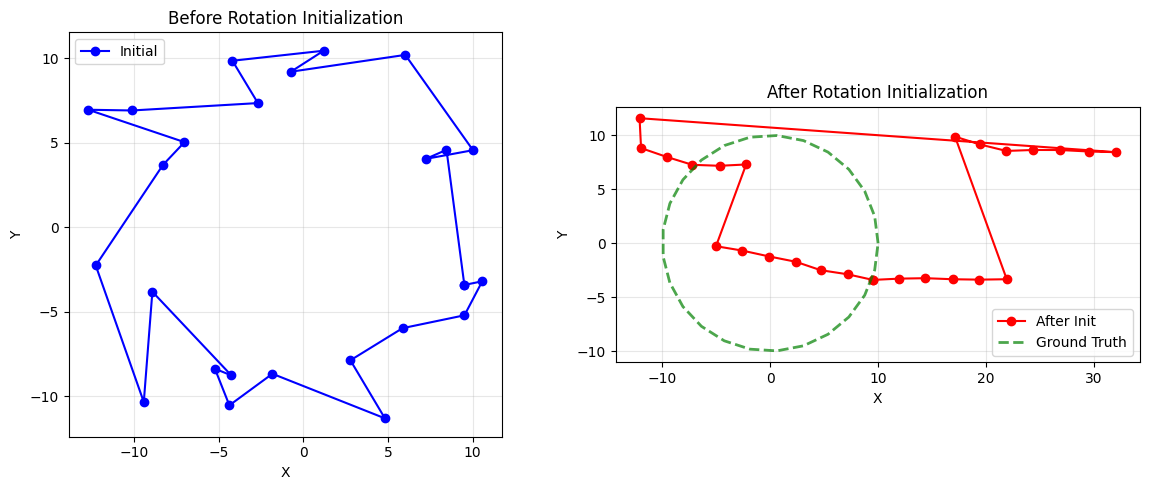

In [29]:
# Create a test scenario
def create_circle_trajectory_with_noise(n_poses: int = 30, radius: float = 10.0,
                                       noise_trans: float = 0.1, 
                                       noise_rot: float = 0.05) -> PoseGraphWithRotationInit:
    graph = PoseGraphWithRotationInit()
    
    # Create circular trajectory
    angles = np.linspace(0, 2*np.pi, n_poses, endpoint=False)
    
    for i, angle in enumerate(angles):
        # Ground truth pose
        x_true = radius * np.cos(angle)
        y_true = radius * np.sin(angle)
        theta_true = angle + np.pi/2
        
        # Add with large initial error
        x_init = x_true + np.random.normal(0, 2.0)
        y_init = y_true + np.random.normal(0, 2.0)
        theta_init = theta_true + np.random.normal(0, 0.5)
        
        graph.add_vertex(i, x_init, y_init, theta_init)
    
    # Add sequential edges
    for i in range(n_poses):
        j = (i + 1) % n_poses
        
        # True relative pose
        angle_diff = 2 * np.pi / n_poses
        dx_true = 2 * radius * np.sin(angle_diff / 2)
        dy_true = 0
        dtheta_true = angle_diff
        
        # Add noise
        dx = dx_true + np.random.normal(0, noise_trans)
        dy = dy_true + np.random.normal(0, noise_trans)
        dtheta = dtheta_true + np.random.normal(0, noise_rot)
        
        graph.add_edge(i, j, dx, dy, dtheta)
    
    # Add some loop closures
    for _ in range(5):
        i = np.random.randint(0, n_poses - 5)
        j = i + np.random.randint(5, min(n_poses - i, 10))
        
        # Compute relative pose with more noise
        angle_i = angles[i] + np.pi/2
        angle_j = angles[j] + np.pi/2
        
        dx_global = radius * (np.cos(angles[j]) - np.cos(angles[i]))
        dy_global = radius * (np.sin(angles[j]) - np.sin(angles[i]))
        
        c = np.cos(angle_i)
        s = np.sin(angle_i)
        dx_local = c * dx_global + s * dy_global
        dy_local = -s * dx_global + c * dy_global
        dtheta = angle_j - angle_i
        
        # Add more noise to loop closures
        dx_local += np.random.normal(0, noise_trans * 2)
        dy_local += np.random.normal(0, noise_trans * 2)
        dtheta += np.random.normal(0, noise_rot * 2)
        
        graph.add_edge(i, j, dx_local, dy_local, dtheta)
    
    return graph

# Test initialization methods
graph = create_circle_trajectory_with_noise(n_poses=25)

# Store initial poses
initial_poses = {k: v.copy() for k, v in graph.vertices.items()}

# Initialize with rotation synchronization
graph.initialize_with_rotation_sync(method='chordal')

# Visualize before and after
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before initialization
ax = axes[0]
poses = [initial_poses[i] for i in sorted(initial_poses.keys())]
x_coords = [p[0] for p in poses]
y_coords = [p[1] for p in poses]
ax.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], 'bo-', 
        markersize=6, label='Initial')
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Before Rotation Initialization')
ax.grid(True, alpha=0.3)
ax.legend()

# After initialization
ax = axes[1]
poses = [graph.vertices[i] for i in sorted(graph.vertices.keys())]
x_coords = [p[0] for p in poses]
y_coords = [p[1] for p in poses]
ax.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], 'ro-', 
        markersize=6, label='After Init')

# Plot ground truth for reference
angles = np.linspace(0, 2*np.pi, len(poses), endpoint=False)
x_true = [10 * np.cos(a) for a in angles]
y_true = [10 * np.sin(a) for a in angles]
ax.plot(x_true + [x_true[0]], y_true + [y_true[0]], 'g--', 
        linewidth=2, alpha=0.7, label='Ground Truth')

ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('After Rotation Initialization')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Summary

In this chapter, we learned:

1. **Why initialization matters** 🏗️
   - Avoids local minima, ensures convergence
   - Critical for real-world SLAM success
   - Bad initialization → complete failure

2. **The rotation synchronization problem** 🧭
   - Finding absolute from relative orientations
   - Like synchronizing compasses or dancers
   - Foundation for pose graph initialization

3. **Chordal relaxation** 📐
   - Brilliant trick: relax SO(3) constraints
   - Convert to convex problem
   - Fast, global solution for dense graphs

4. **Iterative methods** 🔄
   - Consensus-based approach
   - Better for sparse graphs and outliers
   - Can incorporate robust kernels

5. **Practical guidance** 📊
   - Dense + clean → Chordal
   - Sparse + noisy → Iterative
   - Always visualize and verify!

6. **Modern SLAM integration** 🌟
   - Sensor fusion for better initialization
   - Hierarchical approaches work best
   - Learning-based methods emerging

### 🔑 Key Takeaways:
- **Good initialization is not optional** - it's essential for SLAM
- **Chordal relaxation** provides fast, accurate initialization for rotation
- **Choose methods based on your graph** structure and noise characteristics
- **Modern systems combine multiple strategies** for robustness
- **Always test initialization** before running full optimization

### 🚀 Next Chapter: 
We'll explore advanced topics including loop closure detection and global optimization strategies!

## 9. Exercise: Distributed Rotation Averaging

Implement a distributed version of rotation averaging where each node only communicates with its neighbors:

Testing distributed rotation averaging...
Created graph with 15 vertices and 35 edges

Distributed Rotation Averaging:
  mean: 1.0462 rad (59.94 deg)
  max: 2.6068 rad (149.36 deg)
  median: 0.8139 rad (46.63 deg)
  std: 0.8510 rad (48.76 deg)


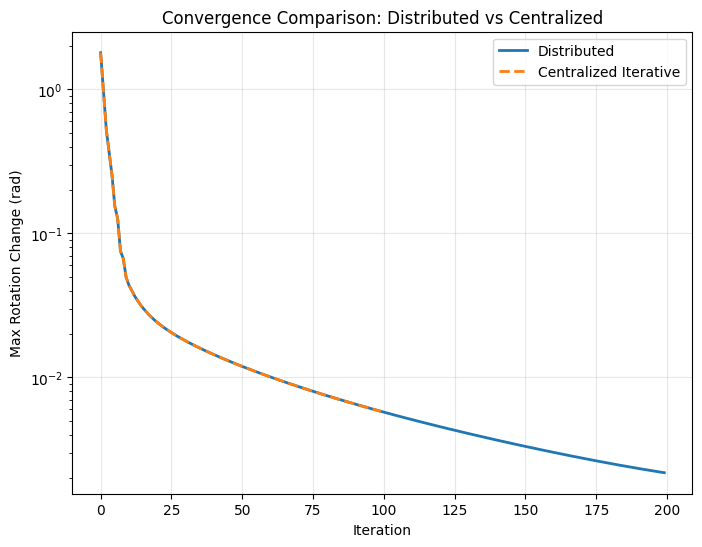

In [30]:
class DistributedRotationAveraging:
    def __init__(self, graph: RotationGraph):
        self.graph = graph
        self.build_adjacency()
    
    def build_adjacency(self):
        """Build adjacency list for the graph"""
        self.neighbors = {v: [] for v in self.graph.vertices}
        
        for i, j, R_ij, weight in self.graph.edges:
            self.neighbors[i].append((j, R_ij, weight))
            self.neighbors[j].append((i, R_ij.T, weight))
    
    def local_update(self, v: int, rotations: Dict[int, np.ndarray]) -> np.ndarray:
        """Update rotation for vertex v based only on neighbors"""
        # Collect measurements from neighbors
        tangent_sum = np.zeros(3)
        weight_sum = 0
        
        for neighbor, R_rel, weight in self.neighbors[v]:
            # Target rotation: R_neighbor * R_rel^T
            R_target = rotations[neighbor] @ R_rel.T
            
            # Compute relative rotation in tangent space
            tangent = log_SO3(R_target @ rotations[v].T)
            
            tangent_sum += weight * tangent
            weight_sum += weight
        
        if weight_sum > 0:
            # Weighted average in tangent space
            avg_tangent = tangent_sum / weight_sum
            
            # Update rotation
            return exp_SO3(avg_tangent) @ rotations[v]
        else:
            return rotations[v]
    
    def solve(self, max_iterations: int = 100, 
              tolerance: float = 1e-6,
              anchor_id: int = 0) -> Dict[int, np.ndarray]:
        """Solve using distributed consensus"""
        # Initialize rotations randomly
        rotations = {}
        for v in self.graph.vertices:
            if v == anchor_id:
                rotations[v] = np.eye(3)
            else:
                # Random rotation
                axis = np.random.randn(3)
                axis /= np.linalg.norm(axis)
                angle = np.random.uniform(0, 2*np.pi)
                rotations[v] = rotation_matrix_from_axis_angle(axis, angle)
        
        history = []
        
        for iteration in range(max_iterations):
            # Store old rotations
            old_rotations = {k: v.copy() for k, v in rotations.items()}
            
            # Update each rotation (except anchor)
            for v in self.graph.vertices:
                if v != anchor_id:
                    rotations[v] = self.local_update(v, old_rotations)
            
            # Compute change
            max_change = 0
            for v in self.graph.vertices:
                change = geodesic_distance_SO3(old_rotations[v], rotations[v])
                max_change = max(max_change, change)
            
            history.append(max_change)
            
            if max_change < tolerance:
                print(f"Distributed algorithm converged after {iteration + 1} iterations")
                break
        
        return rotations, history

# Test the distributed algorithm
print("Testing distributed rotation averaging...")
np.random.seed(42)
graph_dist, ground_truth_dist = create_synthetic_rotation_graph(n_vertices=15, 
                                                               connectivity=0.4,
                                                               noise_level=0.1)

# Solve with distributed method
solver_dist = DistributedRotationAveraging(graph_dist)
rotations_dist, history_dist = solver_dist.solve(max_iterations=200)

# Compute errors
errors_dist = compute_rotation_errors(rotations_dist, ground_truth_dist)

print(f"\nDistributed Rotation Averaging:")
for metric, value in errors_dist.items():
    print(f"  {metric}: {value:.4f} rad ({np.degrees(value):.2f} deg)")

# Plot convergence comparison
plt.figure(figsize=(8, 6))
plt.semilogy(history_dist, linewidth=2, label='Distributed')
if 'history_iterative' in locals():
    plt.semilogy(history_iterative, linewidth=2, label='Centralized Iterative', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Max Rotation Change (rad)')
plt.title('Convergence Comparison: Distributed vs Centralized')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary

In this chapter, we learned:

1. **The rotation synchronization problem** and its importance for initialization
2. **Chordal relaxation** - converting SO(3) constraints to a convex problem
3. **Spectral methods** for solving rotation synchronization
4. **Iterative rotation averaging** using tangent space updates
5. How to **handle outliers** in rotation measurements
6. **Integration with pose graph optimization** for better initialization

Key takeaways:
- Good rotation initialization dramatically improves pose graph convergence
- Chordal relaxation provides a fast, globally optimal solution (without SO(3) constraints)
- Iterative methods can refine solutions and handle constraints better
- Rotation synchronization is more robust than incremental initialization

Next chapter: We'll explore advanced topics including loop closure detection and global optimization strategies!